# Fractals, Newton's Method, and the Roots of Unity

This is a tutorial giving an interactive introduction to the Newton-Rhapson method for solving equations, where we are going to be producing some cool pictures as seen below. You can download this file from [this GitHub repository](https://github.com/CodyEthanJordan/TutorialNotebooks/blob/master/Fractals%2C%20Newton's%20Method%2C%20and%20the%20Roots%20of%20Unity%2C%20A%20Tutorial.ipynb) and run the code yourself, or if you don't have Jupyter notebooks installed on your machine [you can try this version online](https://mybinder.org/v2/gh/CodyEthanJordan/TutorialNotebooks/master?filepath=Fractals%2C%20Newton's%20Method%2C%20and%20the%20Roots%20of%20Unity%2C%20A%20Tutorial.ipynb)

![Z^3 -1 = 0 basins of attraction](fractal.png)

#### What you should know

- Basic familiarity with Python. For more on that I'd reccomend [Think Python 2e](http://greenteapress.com/wp/think-python-2e/)
- Working knowledge of complex numbers. [Paul's Notes](http://tutorial.math.lamar.edu/Extras/ComplexPrimer/ComplexNumbers.aspx) is a great resouce for math subjects, in particular polar and exponential form is good to know


#### What we will cover

- Introduction to numerical methods, in particular the [Newton-Rhapson method](http://mathworld.wolfram.com/NewtonsMethod.html)
- How to use Python to make fractals from the basins of attraction from $z^3-1=0$ and other roots of unity

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Root Finding with Newton

why root finding
Make parabola

Text(0.5,1,'$y = x^2 - 4$')

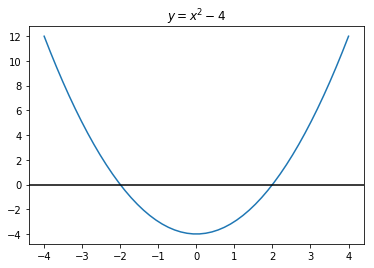

In [12]:
parabola = lambda x : x**2 - 4
parabolaSlope = lambda x : 2*x # this is the derivative of our function 
domain = np.linspace(-4,4)
plt.plot(domain, parabola(domain))
plt.axhline(0, color='black')
plt.title('$y = x^2 - 4$')

Roots obviously at -2, 2

Explain motivation

Explain neton's method

In [10]:
# pretend we are Newton-Rhapson
initialGuess = 4
tolerance = 0.1 # how close to 0 is good enough
if abs(parabola(initialGuess)) <= tolerance:
    print("We did it! Function has a 0 at " + str(initialGuess))
else:
    print("More work to do")

More work to do


In [13]:
offsetToNextGuess = -parabola(initialGuess) / parabolaSlope(initialGuess)
newGuess = initialGuess + offsetToNextGuess
print(newGuess)

2.5


iterations required slider

# Roots of Unity

Look at $z^2 = 1$, what 


In [2]:
g = lambda x, y: x**3 - 3*x*y**2 - 1
h = lambda x, y: 3*x**2 * y - y**3
gx = lambda x, y: 3*x**2 - 3*y**2
gy = lambda x, y: -6*x*y
hx = lambda x, y: 6*x*y
hy = lambda x, y: 3*x**2 - 3*y**2

# render a PIXELS x PIXELS grid in the defined square
PIXELS = 400
minX = -1
maxX = 1
minY = -1
maxY = 1
points = np.array(np.meshgrid(np.linspace(minX, maxX, PIXELS),
    np.linspace(minY, maxY, PIXELS)))
colors = np.zeros((PIXELS, PIXELS))

In [3]:
def newtonIteration(point, g, h, gx, gy, hx, hy):
    x = point[0]
    y = point[1]
    nextX = x - (g(x,y)*hy(x,y) - h(x,y)*gy(x,y)) / (gx(x,y)*hy(x,y) - gy(x,y)*hx(x,y))
    nextY = y - (h(x,y)*gx(x,y) - g(x,y)*hx(x,y)) / (gx(x,y)*hy(x,y) - gy(x,y)*hx(x,y))
    return (nextX, nextY)

def delta(i, j):
    return (i[0] - j[0])**2 + (i[1]-j[1])**2

def complexNewton(initial, epsilon, maxIterations, g, h, gx, gy, hx, hy):
    current = initial
    prev = (np.inf, np.inf)
    iterations = 0
    while delta(prev, current) > epsilon:
        prev = current
        current = newtonIteration(current, g, h, gx, gy, hx, hy)
        iterations = iterations + 1
        if iterations > maxIterations:
            return (np.nan, np.nan)
    return current

In [4]:
for x in range(PIXELS):
    for y in range(PIXELS):
        zeroFound = complexNewton(points[:, x, y], 0.0001, 10, g, h, gx, gy, hx, hy)
        colors[x,y] = np.sum(zeroFound)    

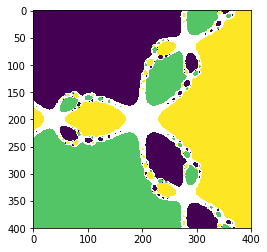

In [5]:
plt.imshow(colors)


### Future Considerations

- How can this algorithm be improved by being parallel, very slow
- Different language? overhead?
- Recompute lots of values, can store calculations
- Floating point errors

talked about Kill Math, mention TryGit tutorial and anaconda installation